In [1]:
using DynamicalSystems, PyPlot

## Orbit Diagram

Shows the long-term behavior of a system when a parameter is varied

Evolves the system for an amount of time, then changes a parameter and repeats, for each parameter

Related to the (more advanced) sensitivity analysis from DifferentialEquations.jl

Orbit diagram of the logistic map:

$$ x_{n+1} = rx_n(1-x_n) $$

In [2]:
logimap = Systems.logistic()

1-dimensional discrete dynamical system
 state:       0.3898224899365281
 e.o.m.:      logistic_eom
 in-place?    false
 jacobian:    logistic_jacob
 parameters:  [4.0]

In [3]:
i = 1 # system is 1D anyway
n = 2000 # no. values to save
Ttr = 2000 # transient iterations
p_index = 1
pvalues = 2:0.001:4 # parameter values
output = orbitdiagram(logimap, i, p_index, pvalues; n=n, Ttr=Ttr)
typeof(output)

Array{Array{Float64,1},1}

In [4]:
function plot_od(r1, r2, n = 2000, Ttr = 1000)
    params = range(r1, stop = r2, length = 2001)
    res = orbitdiagram(logimap, 1, 1, params; n = n, Ttr = Ttr)
    title = "computed points: $(Float64(length(res)*(n+Ttr))), plotted: $(Float64(length(res)*n))"
    L = length(params)

    # Convert all orbit diagram to single vectors (faster to plot)
    x = Vector{Float64}(undef, n*L)
    y = copy(x)
    for j in 1:L
        x[(1 + (j-1)*n):j*n] .= params[j]
        y[(1 + (j-1)*n):j*n] .= res[j]
    end

    figure(figsize = (8,6))
    PyPlot.title(title)
    plot(x, y, ls = "None", ms = 0.2, color = "black", marker = "o", alpha = 0.05)
    xlim(r1, r2); ylim(0,1)
    xlabel("\$r\$"); ylabel("\$x\$")
    tight_layout()

end

plot_od (generic function with 3 methods)

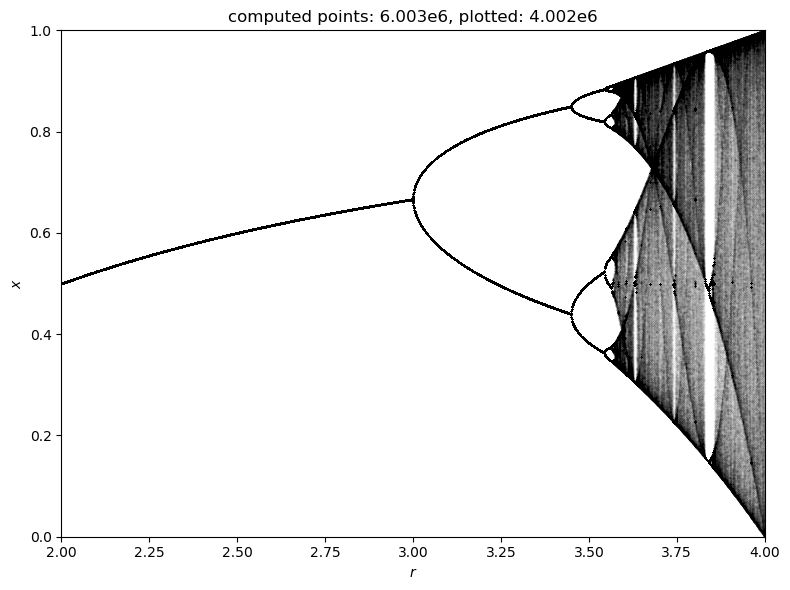

In [5]:
plot_od(2.0, 4.0)

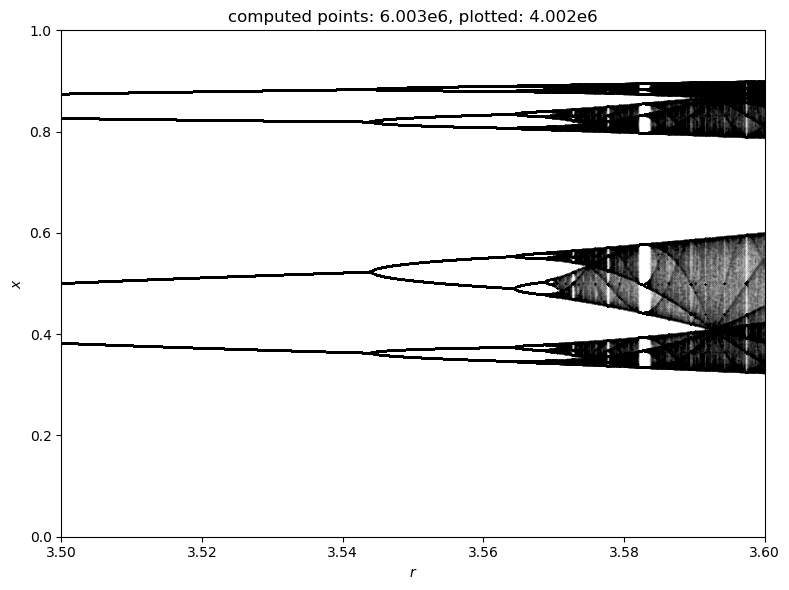

In [15]:
plot_od(3.5, 3.6)

This orbit diagram is infinitely self-similar (kewl)

## Poincare Surface of a Section

Record how many times a system crosses a specified hyperplane in one direction (positive or negative)

A hyperplane in D-dimensional phase-space is:

$$ \mathbf a \cdot \mathbf u = b $$

where **a**, b are the hyperplane parameters and **u** is the state of the system.

Lorenz system:

$$ \dot X = \sigma(Y-X) $$
$$ \dot Y = -XZ + \rho X - Y $$
$$ \dot Z = XY - \beta Z $$

In [16]:
lor = Systems.lorenz()

3-dimensional continuous dynamical system
 state:       [0.0, 10.0, 0.0]
 e.o.m.:      loop
 in-place?    false
 jacobian:    loop_jac
 parameters:  [10.0, 28.0, 2.66667]

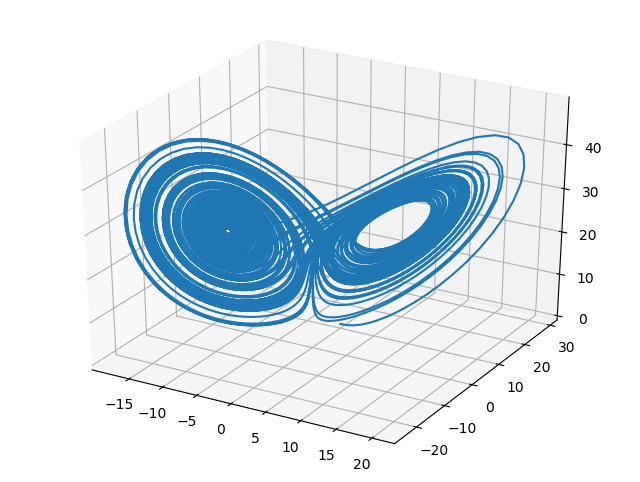

1-element Array{PyCall.PyObject,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x000000004ABC6E80>

In [17]:
tr = trajectory(lor, 100.0, dt=0.01);
figure(figsize=(8,6))
plot3D(columns(tr)...)

In [18]:
psos = poincaresos(lor, (2, 0.0), 2000.0); # where second variable crosses 0.0

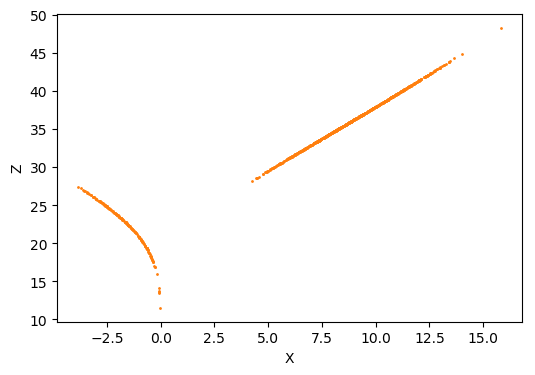

In [19]:
figure(figsize = (6,4))
plot(psos[:, 1], psos[:, 3], lw=0.0, marker ="o", ms = 1.0, color = "C1");
xlabel("X"); ylabel("Z");

This looks 1-D because the Lorenz system (with these default parameters at least) lives almost entirely on a 2D surface

In [20]:
function meshgrid(vx, vy)
    m, n = length(vy), length(vx)
    vx = reshape(vx, 1, n)
    vy = reshape(vy, m, 1)
    (repeat(vx, m, 1), repeat(vy, 1, n))
end

meshgrid (generic function with 1 method)

In [21]:
tr = trajectory(lor, 200.0, dt=0.01)
x, y, z = columns(tr);

c = Vector{String}(undef, length(y))
for i in 1:length(y) # cut points: red
    if -0.1 < y[i] < 0.1
        c[i] = "C3"
    elseif y[i] < 0 
        c[i] = "C0" # in front of cut: blue
    else
        c[i] = "C2" # behind cut: green
    end
end

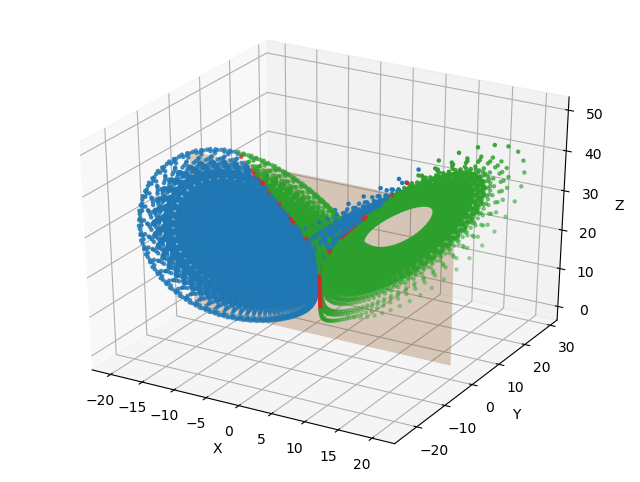

In [26]:
figure(figsize = (8,6))
# First let's plot the attractor
plot3D(x,y,z, color = "black", lw = 0.2, alpha = 0.25)
scatter3D(x, y, z, color = c, s = 5.0)

# And then plot the PSOS plane:
xx = [-20, 20]; zz = [0, 40]; 
X, Z = meshgrid(xx, zz)
Y = zero(X)

plot_surface(X, Y, Z, alpha = 0.25, color = "C1");
xlabel("X"); ylabel("Y"); zlabel("Z");

Green are behind the section, blue in front

## Producing an orbit diagram for a continuous system

We use the Poincare SOS to translate it into a map

In [27]:
shinriki_voltage(V) = 2.295e-5*(exp(3.0038*V) - exp(-3.0038*V))
function shinriki_eom(u, p, t)
    R1 = p[1]

    du1 = (1/0.01)*(
    u[1]*(1/6.9 - 1/R1) - shinriki_voltage(u[1] - u[2]) - (u[1] - u[2])/14.5
    )

    du2 = (1/0.1)*(
    shinriki_voltage(u[1] - u[2]) + (u[1] - u[2])/14.5 - u[3]
    )

    du3 = (1/0.32)*(-u[3]*0.1 + u[2])
    return SVector{3}(du1, du2, du3)
end

# Be sure to give a mutable container for the parameter container!
shi = ContinuousDynamicalSystem(shinriki_eom, [-2, 0, 0.2], [22.0])

3-dimensional continuous dynamical system
 state:       [-2.0, 0.0, 0.2]
 e.o.m.:      shinriki_eom
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [22.0]

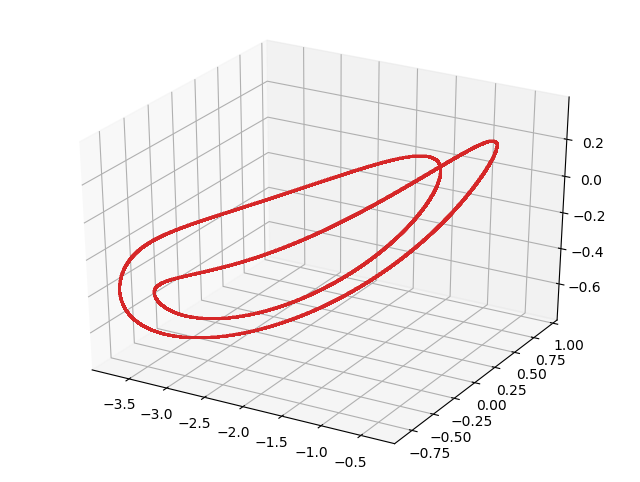

In [28]:
set_parameter!(shi, 1, 20.0) # parameter from 19 to 22
tr = trajectory(shi, 2000.0)
figure(figsize = (8,6))
plot3D(columns(tr[1000:end, :])..., color = "C3", alpha = 0.5, marker = "o", ms = 0.5);

A couple Poincare SOSs:

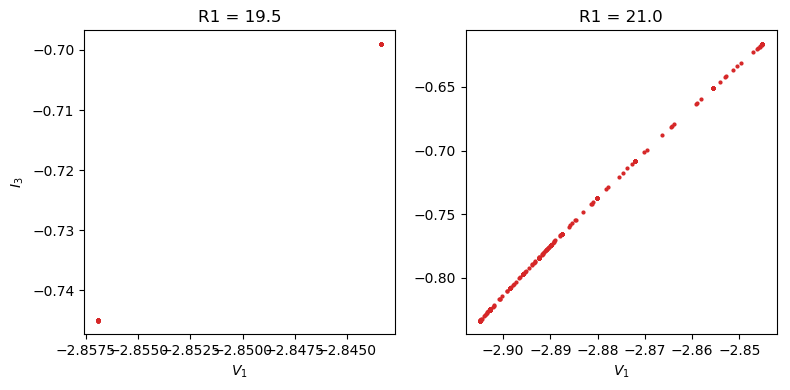

In [29]:
figure(figsize=(8,4))
subplot(1,2,1)
# the function set_parameter! is useful here! (see docstring!)
R1 = 19.5
set_parameter!(shi, 1, R1)

# here I use `direction = -1` (makes more sense for the specific system)
psos = poincaresos(shi, (2, 0.0), 1000.0, Ttr = 100.0, direction = -1)

plot(psos[:, 1], psos[:, 3], lw=0.0, marker ="o", ms = 2.0, color = "C3");
xlabel("\$V_1\$"); ylabel("\$I_3\$")
title("R1 = $R1")

R1 = 21.0
set_parameter!(shi, 1, R1)
subplot(1,2,2)
psos = poincaresos(shi, (2, 0.0), 1000.0, Ttr = 100.0, direction = -1)
plot(psos[:, 1], psos[:, 3], lw=0.0, marker ="o", ms = 2.0, color = "C3");
xlabel("\$V_1\$"); 
title("R1 = $R1");
tight_layout()

Left: system clearly periodic. Right: holy shitcakes. It looks chaotic (but isn't)

In [32]:
pvalues = range(19,stop=22,length=201) # which parameter values to use
p_index = 1 # which parameter to change

i = 1                  # record 1st variable
plane = (2, 0.0)       # find PSOS of 2nd variable when crossing zero
tf = 200.0             # argument passed to poincaresos

200.0

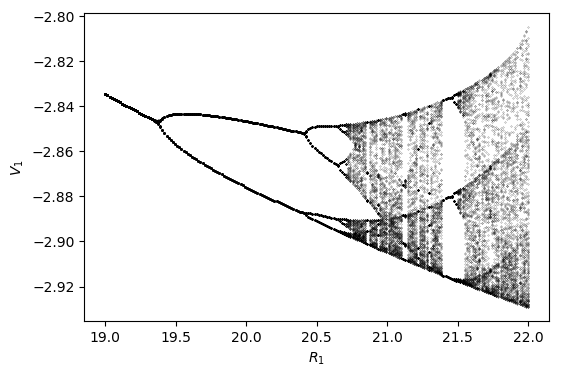

  5.785023 seconds (1.54 M allocations: 42.393 MiB, 0.32% gc time)


In [33]:
@time output = produce_orbitdiagram(shi, plane, i, p_index, pvalues; 
                              # all keywords are passed to poincaresos:
                              tfinal = tf, Ttr = 200.0, direction = -1)

figure(figsize=(6,4))

for (j, p) in enumerate(pvalues)
    plot(p .* ones(length(output[j])), output[j], ls = "None",
    marker = "o", ms = 0.2, alpha = 0.75, color = "black")
end
xlabel("\$R_1\$"); ylabel("\$V_1\$");